# ResNet 分类 CIFAR-10

这里采用 torchvison 中提供的 ResNet 模型并加载预训练参数，对模型进行少量修改后用于 CIFAR-10 数据集的分类。

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
batch_size = 256

## CIFAR-10

CIFAR-10 是一个图像分类数据集，其中包括 10 个类别的 60000 张 32x32 彩色图像，每个类别 6000 张。整个数据集被分为了 50000 张图像的训练集和 10000 张图像的测试集。

这里对训练集做了如下数据增强:
- 边缘 padding 4 像素之后再随机裁剪 32x32
- 随机进行水平翻转

In [3]:
train_transforms = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=train_transforms,
)
test_dataset = datasets.CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=test_transforms,
)

len(train_dataset), len(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


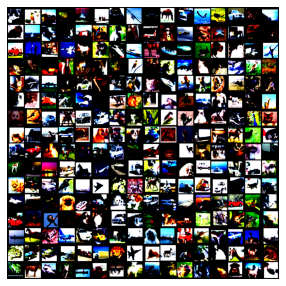

In [5]:
# 取出一个批量的图片
X, y = next(iter(train_dataloader))
plt.figure(figsize=(10, 5))
plt.imshow(torchvision.utils.make_grid(X, nrow=16).permute([1, 2, 0]))
plt.axis("off")
plt.show()

## 建立模型

In [6]:
class ResNet(nn.Module):
    def __init__(self, pretrained: bool=True):
        super(ResNet, self).__init__()
        # 这里不能通过num_classes参数指定类别数量为10，否则会造成预先训练参数加载失败
        self.resnet = models.resnet18(pretrained=pretrained)
        # 修改模型的第一个卷积层和并删除最后一个池化层
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.resnet.maxpool = nn.Identity()
        # 修改模型的最后一层为10个输出，对应于CIFAR-10的10个类别
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)
        
        
    def forward(self, x):
        return self.resnet(x)

## 训练模型

In [7]:
def train(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    test_dataloader: DataLoader, 
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer, 
    device: str
):
    model.to(device)
    model.train()
    for i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"train loss: {loss.item():.4f}")
            
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            pred_y = F.softmax(pred, dim=1).argmax(1)
            correct += torch.sum(pred_y == y).item()
    test_loss = torch.tensor(losses).mean().item()
    test_acc = correct/len(test_dataloader.dataset) * 100
    print(f"test loss: {test_loss:.4f}, test acc: {test_acc:.2f}")
    return test_loss, test_acc

In [8]:
device = "cuda:1"
epochs = 20

In [17]:
model = ResNet(pretrained=True)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

test_loss = []
test_acc = []
lr = []

for t in range(epochs):
    lr.append(optimizer.param_groups[0]['lr'])
    print(f"Epoch {t+1}: lr={optimizer.param_groups[0]['lr']}")
    loss, acc = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, device)
    test_loss.append(loss)
    test_acc.append(acc)
    scheduler.step()
print("Done!")

Epoch 1: lr=0.0001
train loss: 2.6342
train loss: 0.9633
train loss: 0.8018
train loss: 0.6746
test loss: 0.5644, test acc: 80.37
Epoch 2: lr=0.0001
train loss: 0.6032
train loss: 0.4891
train loss: 0.5711
train loss: 0.4651
test loss: 0.4185, test acc: 85.87
Epoch 3: lr=0.0001
train loss: 0.2848
train loss: 0.3338
train loss: 0.3173
train loss: 0.3694
test loss: 0.3588, test acc: 88.38
Epoch 4: lr=0.0001
train loss: 0.2285
train loss: 0.2469
train loss: 0.2866
train loss: 0.1933
test loss: 0.3347, test acc: 89.09
Epoch 5: lr=0.0001
train loss: 0.2040
train loss: 0.2100
train loss: 0.2418
train loss: 0.2473
test loss: 0.3148, test acc: 89.80
Epoch 6: lr=5e-05
train loss: 0.1897
train loss: 0.1212
train loss: 0.1651
train loss: 0.0996
test loss: 0.2785, test acc: 91.24
Epoch 7: lr=5e-05
train loss: 0.1148
train loss: 0.1307
train loss: 0.1236
train loss: 0.1384
test loss: 0.2795, test acc: 91.28
Epoch 8: lr=5e-05
train loss: 0.0859
train loss: 0.1148
train loss: 0.1342
train loss: 0.085

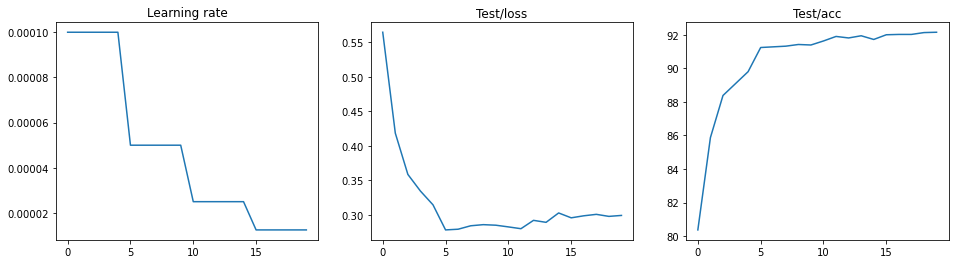

In [18]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(lr)
plt.title("Learning rate")

plt.subplot(1, 3, 2)
plt.plot(test_loss)
plt.title("Test/loss")

plt.subplot(1, 3, 3)
plt.plot(test_acc)
plt.title("Test/acc")
plt.show()

In [33]:
# 预测
X, y = test_dataset[1]
X = X.unsqueeze(dim=0).to(device)
pred_y = F.softmax(model(X), dim=1).argmax(1).item()
y, pred_y

(8, 8)